# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [2]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [3]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [4]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [5]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, std=False, pca=0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        if std:
            mean = train_data.mean(axis=0)
            std = train_data.std(axis=0) + 1e-10
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
            print('Performed standardization')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_ratio_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv
    
    def get_size(self):
        return self.Xt.shape[0], self.Xv.shape[0]

In [6]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [7]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [8]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [9]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [10]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [11]:
class interface():
    def __init__(self, seed = None, build_seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
            
    def train(self, X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=30, **args):
        np.random.seed(self.seed)
        self._check_balanced(y, threshold_unbalanced, args)
        _,_, valid = self._train(X, y, percentage, std, pca, epochs, args)
        if self.unbalanced:
            self._unbal_output(valid)
        self.train_param = (X, y, percentage, std, pca, epochs, args)
            
    def _check_balanced(self, y, threshold_unbalanced, args):
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat] 
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if 'class_weight' in args and args['class_weight'] is None:
                class_weight = {cat: 1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                args['class_weight'] = class_weight
                print('Weights used:', {i:float('%.2f'%class_weight[i]) for i in class_weight})
            unbalanced = True
        self.unbalanced = unbalanced
        
    def _train(self, X, y, percentage, std, pca, epochs, args):
        raise Exception('not implemented')
            
    def _unbal_output(self, valid):
        Xv, yv = valid
        obj = self.obj
        d_cat = {}
        for i in yv:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
        mask = yv != max_cat
        if np.sum(mask) == 0:
            raise Exception('No data in smaller part of valid set')
        minority_score = obj.score(Xv[mask], yv[mask])
        majority_score = obj.score(Xv[~mask], yv[~mask])
        print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(mask)/len(yv)*100, minority_score))
        print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(~mask)/len(yv)*100, majority_score))
        print('Category histogram in validation set:', d_cat)
            
   
        
    def test(self, n=10):
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            tscores, vscores,_ = self._train(self.train_param)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y, fill_up=False):
        obj = self.obj
        assert y.shape[0] == X.shape[0]
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert to_be_predicted.shape[0] != 0
        prediction = obj.predict(to_be_predicted)
        if fill_up:
            y[mask] = prediction
        return prediction

In [12]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage, f_eta, std, pca, v, build_seed):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores, data.get_valid()

In [13]:
def train_perc_cold(perc, X, y, percentage, max_iter, std, pca, build_seed):
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore, data.get_valid()

In [14]:
class perc(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):
        warm_start = True
        learning_rate = args.get('learning_rate', 'optimal')
        it_interval = args.pop('it_interval', 100)
        power_t = args.get('power_t', 0.5)
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')                
            
        #compute max_iter
        max_iter = epochs * it_interval
        args['max_iter'] = it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(**args)

        param_warm = (perc_, X, y, epochs, args['eta0'], percentage, f_eta, std, pca, True, self.build_seed)
        param_cold = (perc_, X, y, percentage, max_iter, std, pca, self.build_seed)
        
        #perform analysis
        if warm_start:
            tscores, vscores, valid = train_perc_warm(*param_warm)
        else:
            tscores, vscores, valid = train_perc_cold(*param_cold)
            
        self.obj = perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'Perceptron interface'

In [15]:
def train_MLP(ml_perc, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [16]:
class MLP(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):             
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_MLP(*param_warm)
        
        #save settings
        self.obj = ml_perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'MLP interface'

In [17]:
def train_LR(log_reg, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [18]:
class LogReg(interface):
    
    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem 
    #is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
    #Does not work for liblinear solver.

         
    def _train(self, X, y, percentage, std, pca, epochs, args):            
        
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_LR(*param_warm)
        
        #save settings
        self.obj = log_regr_
        return tscores, vscores, valid
    def __str__(self):
        return 'Logistic Regression interface'

In [19]:
def test_sup(X, y, *objs):
    assert X.shape[0] == len(y)
    scores = np.zeros(len(objs))
    c = 0
    plt.figure()
    for obj in objs:
        if not isinstance(obj, interface):
            raise Exception('must pass interface subclass object')
        print(X.shape, y.shape)
        score = obj.obj.score(X, y)
        print(score)
        scores[c] = score
        print(scores)
        c += 1
        print(c)
        plt.plot(c, score, '.', label=str(obj))
    legend = plt.legend(loc=(1.01, 0), shadow=True)
    plt.show()
    i_max = np.argmax(scores)
    print('best is %s with score %.2f' % (str(objs[i_max]), scores[i_max]))

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

In [ ]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

In [ ]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

In [ ]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['NumericAge'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
print(dict_numage_to_agecat)
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
my_perc.predict(X,y)

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['Urban'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
X = df[traffic_columns]
#unbalanced?
#np.bincount(y[~np.isnan(y)].astype(int))
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None))

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]

y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
print(y.unique())
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

### MLP

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_MLP = MLP()

In [ ]:
my_MLP.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-1, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
             alpha = 0.0, tol = -1)

In [ ]:
my_MLP.predict(X,y)

In [ ]:
a = df_clean['OS_clean'].copy()
d = dict()
for i in a:
    d[i] = d.get(i, 0) + 1
d

# Logistic Regression

In [20]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_lr = LogReg()

Performed standardization
performed PCA, number of features: 13, explained variance for component:
 ['0.13', '0.10', '0.10', '0.08', '0.08', '0.08', '0.08', '0.07', '0.07', '0.07', '0.07', '0.06', '0.00']
epoch=0 tscore=0.6464560204953032 vscore=0.6014234875444839
epoch=1 tscore=0.6660973526900086 vscore=0.6120996441281139


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increas

epoch=2 tscore=0.7284372331340735 vscore=0.701067615658363
epoch=3 tscore=0.7386848847139197 vscore=0.708185053380783
epoch=4 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=5 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=6 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=7 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=8 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=9 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=10 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=11 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=12 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=13 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=14 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=15 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=16 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=17 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=18 tscore=0.7378309137489325 vscore=0.7081

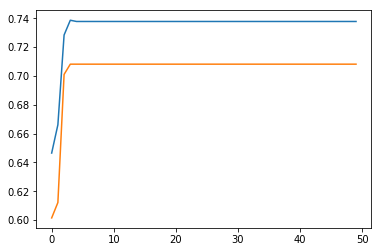

In [21]:
my_lr.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

## Data imputation taken seriously
### OS

In [20]:
df_filled = df_clean.copy()

X = df_filled[traffic_columns]
y = df_filled['OS_clean']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1248, test size 204


run=1 tscore=0.0342397 vscore=0.054902
run=2 tscore=0.0362538 vscore=0.054902
run=3 tscore=0.041289 vscore=0.054902
run=4 tscore=0.0493454 vscore=0.0627451
run=5 tscore=0.0543807 vscore=0.0666667
run=6 tscore=0.060423 vscore=0.101961
run=7 tscore=0.081571 vscore=0.129412
run=8 tscore=0.118832 vscore=0.145098
run=9 tscore=0.176234 vscore=0.176471
run=10 tscore=0.216516 vscore=0.211765
run=11 tscore=0.259819 vscore=0.235294
run=12 tscore=0.296073 vscore=0.254902
run=13 tscore=0.32427 vscore=0.290196
run=14 tscore=0.347432 vscore=0.317647
run=15 tscore=0.365559 vscore=0.337255
run=16 tscore=0.394763 vscore=0.360784
run=17 tscore=0.418933 vscore=0.392157
run=18 tscore=0.437059 vscore=0.415686
run=19 tscore=0.459215 vscore=0.439216
run=20 tscore=0.477341 vscore=0.447059
run=21 tscore=0.487412 vscore=0.454902
run=22 tscore=0.495468 vscore=0.458824
run=23 tscore=0.506546 vscore=0.486275
run=24 tscore=0.521652 vscore=0.505882
run=25 tscore=0.530715 vscore=0.517647
run=26 tscore=0.545821 vscore

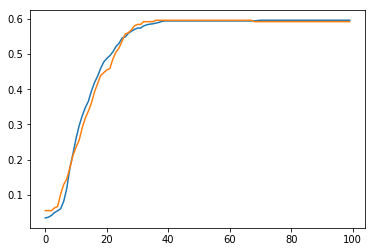

In [21]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=0.8514873819354656 tscore=0.5991943605236657 vscore=0.596078431372549
epoch=1 loss=0.7533919508695252 tscore=0.6042296072507553 vscore=0.611764705882353
epoch=2 loss=0.7369297130758983 tscore=0.6253776435045317 vscore=0.615686274509804
epoch=3 loss=0.7132543764689124 tscore=0.6193353474320241 vscore=0.615686274509804
epoch=4 loss=0.7020505689921989 tscore=0.7220543806646526 vscore=0.7372549019607844
epoch=5 loss=0.695515091261227 tscore=0.756294058408862 vscore=0.7568627450980392
epoch=6 loss=0.6806729091340905 tscore=0.6807653575025177 vscore=0.6784313725490196
epoch=7 loss=0.6717537018692155 tscore=0.6938569989929506 vscore=0.6862745098039216
epoch=8 loss=0.6565938153723518 tscore=0.6777442094662638 vscore=0.6745098039215687
epoch=9 loss=0.6452406254032815 tscore=0.6998992950654582 vscore=0.6901960784313725
epoch=10 loss=0.6444593809570378 tscore=0.7482376636455186 vscore=0.7450980392156863
epoch=11 loss=0.6334196267216899 tscore=0.7341389728096677 vscore=0.7254901960784

epoch=102 loss=0.40482543869816867 tscore=0.877139979859013 vscore=0.8235294117647058
epoch=103 loss=0.3796559968983288 tscore=0.8801611278952669 vscore=0.8392156862745098
epoch=104 loss=0.3713865306033708 tscore=0.877139979859013 vscore=0.8117647058823529
epoch=105 loss=0.3742701637510141 tscore=0.9103726082578046 vscore=0.8431372549019608
epoch=106 loss=0.38576369689274725 tscore=0.8801611278952669 vscore=0.8117647058823529
epoch=107 loss=0.380733226118624 tscore=0.8942598187311178 vscore=0.8352941176470589
epoch=108 loss=0.37803100201963613 tscore=0.9083585095669687 vscore=0.8313725490196079
epoch=109 loss=0.38019639457108606 tscore=0.9023162134944612 vscore=0.8392156862745098
epoch=110 loss=0.3835389362656264 tscore=0.8841893252769386 vscore=0.8313725490196079
epoch=111 loss=0.37793875061059773 tscore=0.8902316213494461 vscore=0.8431372549019608
epoch=112 loss=0.382366025576254 tscore=0.8680765357502518 vscore=0.8117647058823529
epoch=113 loss=0.37829886047178546 tscore=0.886203423

epoch=202 loss=0.38828965159597445 tscore=0.8932527693856999 vscore=0.8196078431372549
epoch=203 loss=0.3748982257241474 tscore=0.9164149043303121 vscore=0.8470588235294118
epoch=204 loss=0.36911917911145664 tscore=0.9144008056394763 vscore=0.8313725490196079
epoch=205 loss=0.36041814353270824 tscore=0.8972809667673716 vscore=0.8352941176470589
epoch=206 loss=0.3639079951484965 tscore=0.9083585095669687 vscore=0.8274509803921568
epoch=207 loss=0.3565443282997069 tscore=0.9123867069486404 vscore=0.8392156862745098
epoch=208 loss=0.36515215575148235 tscore=0.9113796576032226 vscore=0.8235294117647058
epoch=209 loss=0.37069150388306166 tscore=0.9164149043303121 vscore=0.8313725490196079
epoch=210 loss=0.36390750884869943 tscore=0.8851963746223565 vscore=0.8392156862745098
epoch=211 loss=0.36261604501182193 tscore=0.8952668680765358 vscore=0.8313725490196079
epoch=212 loss=0.35986315671311353 tscore=0.9133937562940584 vscore=0.8352941176470589
epoch=213 loss=0.36199168530196113 tscore=0.92

epoch=311 loss=0.3600071855100909 tscore=0.918429003021148 vscore=0.8313725490196079
epoch=312 loss=0.3617352301587044 tscore=0.8872104733131924 vscore=0.8235294117647058
epoch=313 loss=0.35686485464758944 tscore=0.904330312185297 vscore=0.8352941176470589
epoch=314 loss=0.35163891446162454 tscore=0.9144008056394763 vscore=0.8352941176470589
epoch=315 loss=0.35340725929820566 tscore=0.8932527693856999 vscore=0.8352941176470589
epoch=316 loss=0.3541755624358721 tscore=0.9224572004028198 vscore=0.8352941176470589
epoch=317 loss=0.34917614871528513 tscore=0.918429003021148 vscore=0.8274509803921568
epoch=318 loss=0.34659668889092116 tscore=0.9204431017119838 vscore=0.8431372549019608
epoch=319 loss=0.3496142539626656 tscore=0.9123867069486404 vscore=0.8235294117647058
epoch=320 loss=0.35621023709044736 tscore=0.9144008056394763 vscore=0.8431372549019608
epoch=321 loss=0.3556422948372492 tscore=0.9003021148036254 vscore=0.8313725490196079
epoch=322 loss=0.3488744549908243 tscore=0.90735146

epoch=413 loss=0.3500102987325879 tscore=0.9174219536757301 vscore=0.8392156862745098
epoch=414 loss=0.3427945091497012 tscore=0.9254783484390735 vscore=0.8392156862745098
epoch=415 loss=0.3446450412930743 tscore=0.9083585095669687 vscore=0.8313725490196079
epoch=416 loss=0.3498144921176501 tscore=0.9133937562940584 vscore=0.8431372549019608
epoch=417 loss=0.3417439076016837 tscore=0.9284994964753273 vscore=0.8352941176470589
epoch=418 loss=0.3601541529420071 tscore=0.9154078549848943 vscore=0.8470588235294118
epoch=419 loss=0.3511591795803071 tscore=0.919436052366566 vscore=0.8313725490196079
epoch=420 loss=0.37677710651271246 tscore=0.918429003021148 vscore=0.8431372549019608
epoch=421 loss=0.36335269622623645 tscore=0.8972809667673716 vscore=0.8313725490196079
epoch=422 loss=0.36237748927461766 tscore=0.905337361530715 vscore=0.8274509803921568
epoch=423 loss=0.3630032528324768 tscore=0.9234642497482377 vscore=0.8313725490196079
epoch=424 loss=0.3656245283617248 tscore=0.90433031218

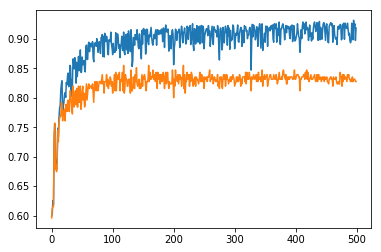

In [22]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=0 tscore=0.5961732124874118 vscore=0.592156862745098
epoch=1 tscore=0.5961732124874118 vscore=0.592156862745098
epoch=2 tscore=0.6132930513595166 vscore=0.611764705882353
epoch=3 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=4 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=5 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=6 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=7 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=8 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=9 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=10 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=11 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=12 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=13 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=14 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=15 tscore=0.6122860020140987 vscore=0.615686274509804
epoch=16 tscore=0.6122860020140987 vscore=0.615686

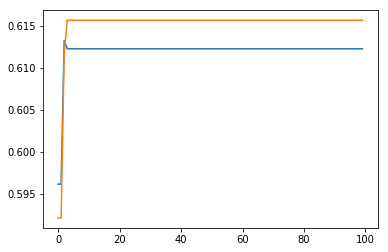

In [23]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(204, 13) (204,)
0.5833333333333334
[0.58333333 0.         0.        ]
1
(204, 13) (204,)
0.8774509803921569
[0.58333333 0.87745098 0.        ]
2
(204, 13) (204,)
0.5637254901960784
[0.58333333 0.87745098 0.56372549]
3


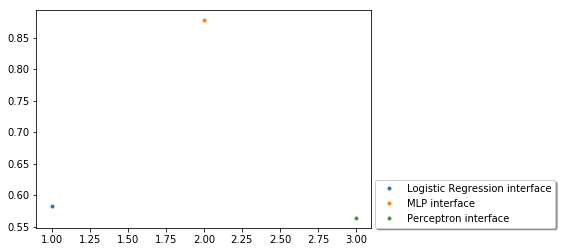

best is MLP interface with score 0.88


In [24]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

Therefore we use this MLP to predict the rest of the column OS and keep the predictions to imput into our dataset later.

In [25]:
os_missing = my_MLP.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Urbanization

In [26]:
X = df_filled[traffic_columns]
y = df_filled['Urban'].map(lambda x: int(x), na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1426, test size 228


run=1 tscore=0.229407 vscore=0.215488
run=2 tscore=0.229407 vscore=0.215488
run=3 tscore=0.228521 vscore=0.215488
run=4 tscore=0.229407 vscore=0.215488
run=5 tscore=0.243578 vscore=0.222222
run=6 tscore=0.264836 vscore=0.225589
run=7 tscore=0.282551 vscore=0.265993
run=8 tscore=0.310009 vscore=0.299663
run=9 tscore=0.342781 vscore=0.329966
run=10 tscore=0.391497 vscore=0.417508
run=11 tscore=0.422498 vscore=0.451178
run=12 tscore=0.427812 vscore=0.451178
run=13 tscore=0.432241 vscore=0.451178
run=14 tscore=0.431355 vscore=0.451178
run=15 tscore=0.431355 vscore=0.451178
run=16 tscore=0.431355 vscore=0.451178
run=17 tscore=0.432241 vscore=0.451178
run=18 tscore=0.431355 vscore=0.451178
run=19 tscore=0.431355 vscore=0.451178
run=20 tscore=0.431355 vscore=0.451178
run=21 tscore=0.431355 vscore=0.451178
run=22 tscore=0.430469 vscore=0.451178
run=23 tscore=0.430469 vscore=0.451178
run=24 tscore=0.430469 vscore=0.451178
run=25 tscore=0.430469 vscore=0.451178
run=26 tscore=0.430469 vscore=0.45

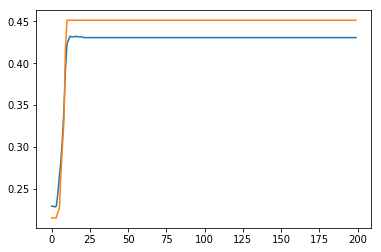

In [27]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=200,  loss='squared_hinge', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

epoch=0 loss=1.1338478583331473 tscore=0.4269264836138175 vscore=0.4511784511784512


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=1 loss=1.1254940540833087 tscore=0.4286979627989371 vscore=0.4511784511784512
epoch=2 loss=1.1185718317162392 tscore=0.4295837023914969 vscore=0.4511784511784512
epoch=3 loss=1.1131276409761166 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=4 loss=1.1083185821855017 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=5 loss=1.1046347605922535 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=6 loss=1.1014742786403866 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=7 loss=1.098910210756215 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=8 loss=1.0968605692430142 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=9 loss=1.0949589226449747 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=10 loss=1.0933264381851384 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=11 loss=1.0921043070687064 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=12 loss=1.0908754648490588 tscore=0.4304694419840567 vscore=0.4511784

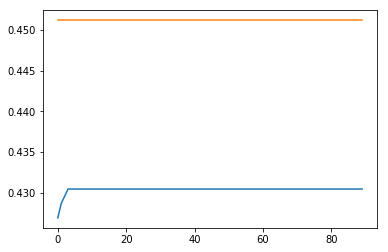

In [28]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=0 tscore=0.4304694419840567 vscore=0.4511784511784512
epoch=1 tscore=0.42515500442869797 vscore=0.45454545454545453
epoch=2 tscore=0.4269264836138175 vscore=0.45454545454545453
epoch=3 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=4 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=5 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=6 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=7 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=8 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=9 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=10 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=11 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=12 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=13 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=14 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch=15 tscore=0.42781222320637735 vscore=0.45454545454545453
epoch

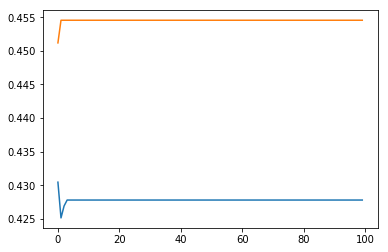

In [29]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(228, 13) (228,)
0.44298245614035087
[0.44298246 0.         0.        ]
1
(228, 13) (228,)
0.4342105263157895
[0.44298246 0.43421053 0.        ]
2
(228, 13) (228,)
0.4342105263157895
[0.44298246 0.43421053 0.43421053]
3


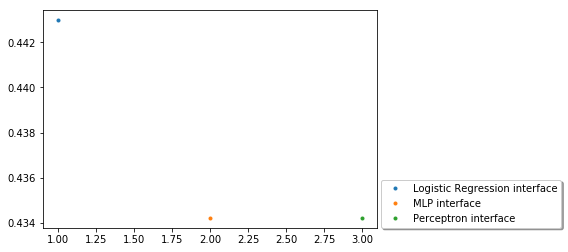

best is Logistic Regression interface with score 0.44


In [30]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

In [31]:
urbanization = my_lr.predict(X,y, fill_up=True)

# Numeric Age

In [32]:
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
df_filled["NumericAge"] = df_filled["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df_filled[traffic_columns]
y = df_filled['NumericAge']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456222
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1591, test size 289


Weights used: {2.0: 227.29, 1.0: 1.55, 0.0: 2.86}
run=1 tscore=0.642072 vscore=0.662461
run=2 tscore=0.642072 vscore=0.662461
run=3 tscore=0.638932 vscore=0.665615
run=4 tscore=0.638148 vscore=0.66877
run=5 tscore=0.635793 vscore=0.665615
run=6 tscore=0.635793 vscore=0.66877
run=7 tscore=0.635008 vscore=0.665615
run=8 tscore=0.635008 vscore=0.656151
run=9 tscore=0.632653 vscore=0.649842
run=10 tscore=0.631868 vscore=0.656151
run=11 tscore=0.634223 vscore=0.652997
run=12 tscore=0.634223 vscore=0.652997
run=13 tscore=0.637363 vscore=0.646688
run=14 tscore=0.632653 vscore=0.643533
run=15 tscore=0.631868 vscore=0.643533
run=16 tscore=0.634223 vscore=0.643533
run=17 tscore=0.634223 vscore=0.643533
run=18 tscore=0.636578 vscore=0.646688
run=19 tscore=0.635793 vscore=0.649842
run=20 tscore=0.631868 vscore=0.649842
run=21 tscore=0.631868 vscore=0.652997
run=22 tscore=0.633438 vscore=0.656151
run=23 tscore=0.629513 vscore=0.649842
run=24 tscore=0.628728 vscore=0.649842
run=25 tscore=0.624804 vs

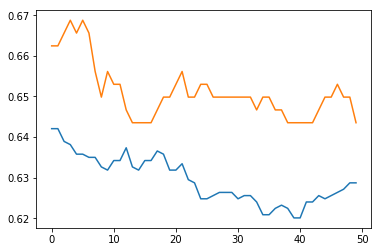

In [33]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight=None)

epoch=0 loss=0.8288057404395368 tscore=0.6232339089481946 vscore=0.6340694006309149
epoch=1 loss=0.6864401084090029 tscore=0.6444270015698587 vscore=0.6624605678233438
epoch=2 loss=0.6702579584112134 tscore=0.6483516483516484 vscore=0.6750788643533123
epoch=3 loss=0.665833201084073 tscore=0.6483516483516484 vscore=0.6624605678233438
epoch=4 loss=0.6645811210755506 tscore=0.6467817896389325 vscore=0.6624605678233438
epoch=5 loss=0.664320738754707 tscore=0.652276295133438 vscore=0.668769716088328
epoch=6 loss=0.6560262269831125 tscore=0.6467817896389325 vscore=0.6624605678233438
epoch=7 loss=0.6564901490393118 tscore=0.6467817896389325 vscore=0.6593059936908517
epoch=8 loss=0.6559176421732602 tscore=0.6554160125588697 vscore=0.668769716088328


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=9 loss=0.6486147855896036 tscore=0.6459968602825745 vscore=0.6593059936908517
epoch=10 loss=0.6581961754546921 tscore=0.6491365777080063 vscore=0.6593059936908517
epoch=11 loss=0.6529147683055171 tscore=0.6507064364207221 vscore=0.6624605678233438
epoch=12 loss=0.6495956091868258 tscore=0.6467817896389325 vscore=0.6593059936908517
epoch=13 loss=0.6496814691557773 tscore=0.6546310832025117 vscore=0.6656151419558359
epoch=14 loss=0.6507801826086822 tscore=0.6546310832025117 vscore=0.6656151419558359
epoch=15 loss=0.6477070681282046 tscore=0.6609105180533752 vscore=0.6498422712933754
epoch=16 loss=0.6496043291398238 tscore=0.6538461538461539 vscore=0.668769716088328
epoch=17 loss=0.6538550977578259 tscore=0.6475667189952904 vscore=0.6561514195583596
epoch=18 loss=0.6561691157439838 tscore=0.6467817896389325 vscore=0.6561514195583596
epoch=19 loss=0.6495868690386214 tscore=0.6546310832025117 vscore=0.668769716088328
epoch=20 loss=0.6476478721358095 tscore=0.6514913657770801 vscore=0.

epoch=111 loss=0.6424764594009056 tscore=0.6616954474097331 vscore=0.668769716088328
epoch=112 loss=0.6451640473628597 tscore=0.6562009419152276 vscore=0.6719242902208202
epoch=113 loss=0.6441838369586987 tscore=0.6538461538461539 vscore=0.6656151419558359
epoch=114 loss=0.641848668253287 tscore=0.6656200941915228 vscore=0.6561514195583596
epoch=115 loss=0.6443503387614448 tscore=0.6546310832025117 vscore=0.6719242902208202
epoch=116 loss=0.6431630661377161 tscore=0.6601255886970173 vscore=0.6498422712933754
epoch=117 loss=0.6436395746080922 tscore=0.6640502354788069 vscore=0.6498422712933754
epoch=118 loss=0.6527693701641376 tscore=0.6491365777080063 vscore=0.6182965299684543
epoch=119 loss=0.649745876701002 tscore=0.6593406593406593 vscore=0.6719242902208202
epoch=120 loss=0.6430779520813397 tscore=0.6538461538461539 vscore=0.6719242902208202
epoch=121 loss=0.6478187269037482 tscore=0.6546310832025117 vscore=0.6719242902208202
epoch=122 loss=0.6424839815929461 tscore=0.65384615384615

epoch=207 loss=0.6405278819882331 tscore=0.6562009419152276 vscore=0.6750788643533123
epoch=208 loss=0.6409913783397194 tscore=0.6577708006279435 vscore=0.6750788643533123
epoch=209 loss=0.6412533203812898 tscore=0.6569858712715856 vscore=0.6719242902208202
epoch=210 loss=0.641515829422365 tscore=0.652276295133438 vscore=0.6656151419558359
epoch=211 loss=0.6419930526902121 tscore=0.6538461538461539 vscore=0.6719242902208202
epoch=212 loss=0.6414986011989829 tscore=0.6562009419152276 vscore=0.6466876971608833
epoch=213 loss=0.6483915479835498 tscore=0.6530612244897959 vscore=0.6656151419558359
epoch=214 loss=0.644423625311765 tscore=0.6546310832025117 vscore=0.6656151419558359
epoch=215 loss=0.6444352366606574 tscore=0.6632653061224489 vscore=0.6561514195583596
epoch=216 loss=0.6426194911682908 tscore=0.6601255886970173 vscore=0.6435331230283912
epoch=217 loss=0.6409175192258907 tscore=0.6530612244897959 vscore=0.6656151419558359
epoch=218 loss=0.643717760192767 tscore=0.653061224489795

epoch=305 loss=0.6401392789226873 tscore=0.6609105180533752 vscore=0.668769716088328
epoch=306 loss=0.639545469278484 tscore=0.6538461538461539 vscore=0.6719242902208202
epoch=307 loss=0.6399690846067214 tscore=0.6554160125588697 vscore=0.6750788643533123
epoch=308 loss=0.6401587811888342 tscore=0.6624803767660911 vscore=0.6529968454258676
epoch=309 loss=0.6454310556765814 tscore=0.6514913657770801 vscore=0.6624605678233438
epoch=310 loss=0.6502287424348717 tscore=0.6514913657770801 vscore=0.6719242902208202
epoch=311 loss=0.6444737492378024 tscore=0.6624803767660911 vscore=0.6435331230283912
epoch=312 loss=0.6445291647222868 tscore=0.6585557299843015 vscore=0.6719242902208202
epoch=313 loss=0.640576283915833 tscore=0.6562009419152276 vscore=0.6656151419558359
epoch=314 loss=0.6405143172499506 tscore=0.6616954474097331 vscore=0.6593059936908517
epoch=315 loss=0.6404706949016288 tscore=0.6530612244897959 vscore=0.6656151419558359
epoch=316 loss=0.642978373362967 tscore=0.659340659340659

epoch=402 loss=0.640419728946547 tscore=0.6593406593406593 vscore=0.6719242902208202
epoch=403 loss=0.6394241135144058 tscore=0.6585557299843015 vscore=0.6656151419558359
epoch=404 loss=0.6395081188858336 tscore=0.6601255886970173 vscore=0.6656151419558359
epoch=405 loss=0.6391855201073822 tscore=0.6562009419152276 vscore=0.6750788643533123
epoch=406 loss=0.6405987689259216 tscore=0.6624803767660911 vscore=0.6529968454258676
epoch=407 loss=0.6383848981116472 tscore=0.6538461538461539 vscore=0.6719242902208202
epoch=408 loss=0.6461622573809905 tscore=0.6530612244897959 vscore=0.6340694006309149
epoch=409 loss=0.6422281566472724 tscore=0.6530612244897959 vscore=0.6750788643533123
epoch=410 loss=0.6440939763790072 tscore=0.6538461538461539 vscore=0.668769716088328
epoch=411 loss=0.6429567170760941 tscore=0.6609105180533752 vscore=0.6719242902208202
epoch=412 loss=0.6424525327606451 tscore=0.6632653061224489 vscore=0.6529968454258676
epoch=413 loss=0.6406823019141036 tscore=0.6530612244897

Score on smaller part (33.75%) of validation set (unbalanced case): 0.16
Score on bigger part (66.25%) of validation set (unbalanced case): 0.90
Category histogram in validation set: {1.0: 210, 0.0: 105, 2.0: 2}


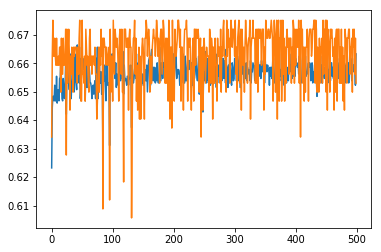

In [34]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.2, tol = 1e-4)

Weights used: {2.0: 227.29, 1.0: 1.55, 0.0: 2.86}
epoch=0 tscore=0.33124018838304553 vscore=0.3438485804416404
epoch=1 tscore=0.4521193092621664 vscore=0.45741324921135645
epoch=2 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=3 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=4 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=5 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=6 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=7 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=8 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=9 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=10 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=11 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=12 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=13 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=14 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=15 tscore=0.4638932496075353 vscore=0

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=43 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=44 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=45 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=46 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=47 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=48 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=49 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=50 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=51 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=52 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=53 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=54 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=55 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=56 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=57 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=58 tscore=0.4638932496075353 vscore=0.4605678233438486
epoch=59 tscore=0.463893

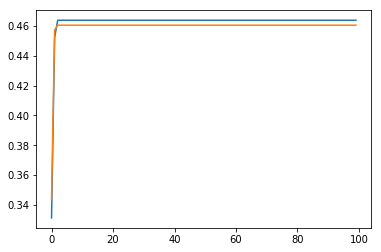

In [35]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(289, 13) (289,)
0.4740484429065744
[0.47404844 0.         0.        ]
1
(289, 13) (289,)
0.6366782006920415
[0.47404844 0.6366782  0.        ]
2
(289, 13) (289,)
0.5674740484429066
[0.47404844 0.6366782  0.56747405]
3


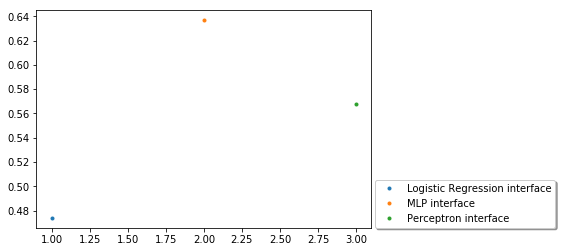

best is MLP interface with score 0.64


In [37]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

In [38]:
num_age = my_MLP.predict(X,y, fill_up=True)

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Data Allowance

In [39]:
#most between 0 and 0.33, cut out outliers and rescale ?

X = df_filled[traffic_columns]
y = df_filled['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1387, test size 249


run=1 tscore=0.33515 vscore=0.353147
run=2 tscore=0.323342 vscore=0.346154
run=3 tscore=0.339691 vscore=0.346154
run=4 tscore=0.319709 vscore=0.318182
run=5 tscore=0.337875 vscore=0.342657
run=6 tscore=0.337875 vscore=0.325175
run=7 tscore=0.343324 vscore=0.339161
run=8 tscore=0.344233 vscore=0.342657
run=9 tscore=0.337875 vscore=0.328671
run=10 tscore=0.341508 vscore=0.321678
run=11 tscore=0.337875 vscore=0.339161
run=12 tscore=0.345141 vscore=0.339161
run=13 tscore=0.337875 vscore=0.339161
run=14 tscore=0.340599 vscore=0.353147
run=15 tscore=0.337875 vscore=0.339161
run=16 tscore=0.343324 vscore=0.34965
run=17 tscore=0.338783 vscore=0.342657
run=18 tscore=0.342416 vscore=0.346154
run=19 tscore=0.341508 vscore=0.346154
run=20 tscore=0.336966 vscore=0.34965
run=21 tscore=0.343324 vscore=0.339161
run=22 tscore=0.340599 vscore=0.34965
run=23 tscore=0.339691 vscore=0.342657
run=24 tscore=0.340599 vscore=0.356643
run=25 tscore=0.338783 vscore=0.346154
run=26 tscore=0.340599 vscore=0.34965


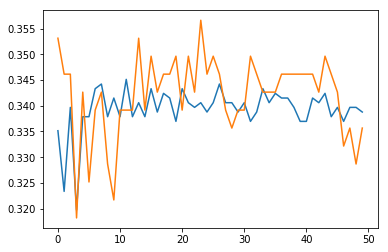

In [40]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=2.307071250577216 tscore=0.23524069028156222 vscore=0.25874125874125875
epoch=1 loss=2.286106670242051 tscore=0.3060853769300636 vscore=0.32167832167832167
epoch=2 loss=2.2669958830272328 tscore=0.3278837420526794 vscore=0.34965034965034963
epoch=3 loss=2.2493435038245346 tscore=0.33242506811989103 vscore=0.35664335664335667
epoch=4 loss=2.233328234356051 tscore=0.3333333333333333 vscore=0.36013986013986016
epoch=5 loss=2.217837630868123 tscore=0.3333333333333333 vscore=0.36013986013986016
epoch=6 loss=2.202888100482292 tscore=0.335149863760218 vscore=0.36013986013986016
epoch=7 loss=2.187965058248766 tscore=0.33605812897366033 vscore=0.36013986013986016
epoch=8 loss=2.1720778800371403 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=9 loss=2.156392100692441 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=10 loss=2.14185338726212 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=11 loss=2.1280638714481075 tscore=0.3369663941871026 vscore=0.360

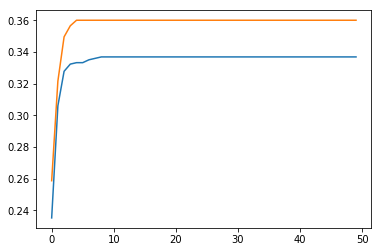

In [41]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (400,), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.05, tol = 1e-4)

(249, 13) (249,)
0.42168674698795183
[0.42168675 0.        ]
1
(249, 13) (249,)
0.41365461847389556
[0.42168675 0.41365462]
2


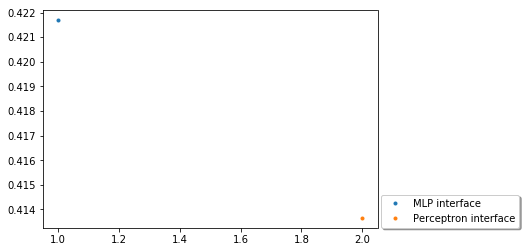

best is MLP interface with score 0.42


In [42]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [43]:
data_all = my_MLP.predict(X,y, fill_up=True)

# Monthly Data Traffic

In [44]:
X = df_filled[traffic_columns]
y = df_filled['MonthlyDataTraffic'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1620, test size 297


Weights used: {'0.2': 17.61, '0.0': 1.58, '0.1': 3.41, '0.5': 540.0, '0.3': 115.71, '0.4': 180.0, '1.0': 810.0, '0.9': 1620.0, '0.7': 1620.0}
run=1 tscore=0.119938 vscore=0.0803571
run=2 tscore=0.391745 vscore=0.383929
run=3 tscore=0.387072 vscore=0.345238
run=4 tscore=0.412773 vscore=0.407738
run=5 tscore=0.390187 vscore=0.366071
run=6 tscore=0.407321 vscore=0.366071
run=7 tscore=0.422118 vscore=0.410714
run=8 tscore=0.383956 vscore=0.357143
run=9 tscore=0.426012 vscore=0.425595
run=10 tscore=0.428349 vscore=0.425595
run=11 tscore=0.419003 vscore=0.425595
run=12 tscore=0.428349 vscore=0.416667
run=13 tscore=0.419782 vscore=0.416667
run=14 tscore=0.408879 vscore=0.404762
run=15 tscore=0.418224 vscore=0.410714
run=16 tscore=0.425234 vscore=0.422619
run=17 tscore=0.428349 vscore=0.431548
run=18 tscore=0.422118 vscore=0.428571
run=19 tscore=0.429128 vscore=0.425595
run=20 tscore=0.355919 vscore=0.35119
run=21 tscore=0.422897 vscore=0.4375
run=22 tscore=0.425234 vscore=0.431548
run=23 tsco

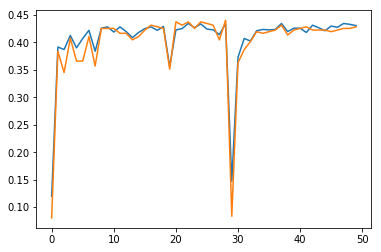

In [45]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.291906380475136 tscore=0.6246105919003115 vscore=0.6577380952380952
epoch=1 loss=0.9491170926026508 tscore=0.6246105919003115 vscore=0.6607142857142857
epoch=2 loss=0.9053933713330712 tscore=0.6253894080996885 vscore=0.6636904761904762
epoch=3 loss=0.878877248688663 tscore=0.6246105919003115 vscore=0.6726190476190477
epoch=4 loss=0.8737609898732962 tscore=0.6246105919003115 vscore=0.6666666666666666
epoch=5 loss=0.8658250308985755 tscore=0.6269470404984424 vscore=0.6547619047619048
epoch=6 loss=0.8646829868106635 tscore=0.6253894080996885 vscore=0.6666666666666666
epoch=7 loss=0.8600080742413007 tscore=0.6269470404984424 vscore=0.6607142857142857


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=8 loss=0.8548309652157281 tscore=0.6207165109034268 vscore=0.6726190476190477
epoch=9 loss=0.8615698249100334 tscore=0.6347352024922118 vscore=0.6636904761904762
epoch=10 loss=0.8539444580038611 tscore=0.6285046728971962 vscore=0.6875
epoch=11 loss=0.8496183657872411 tscore=0.6261682242990654 vscore=0.6577380952380952
epoch=12 loss=0.8461685339484952 tscore=0.6277258566978193 vscore=0.6577380952380952
epoch=13 loss=0.845793532456131 tscore=0.631619937694704 vscore=0.6577380952380952
epoch=14 loss=0.8447276840074347 tscore=0.6300623052959502 vscore=0.6815476190476191
epoch=15 loss=0.8459106701978685 tscore=0.6261682242990654 vscore=0.6577380952380952
epoch=16 loss=0.8489830120254702 tscore=0.631619937694704 vscore=0.6696428571428571
epoch=17 loss=0.8500969950864217 tscore=0.6285046728971962 vscore=0.6547619047619048
epoch=18 loss=0.840332201240167 tscore=0.6277258566978193 vscore=0.6607142857142857
epoch=19 loss=0.8365006541272673 tscore=0.6355140186915887 vscore=0.660714285714285

epoch=110 loss=0.7996675977649851 tscore=0.6612149532710281 vscore=0.6815476190476191
epoch=111 loss=0.7990770827472005 tscore=0.6549844236760125 vscore=0.6934523809523809
epoch=112 loss=0.8011765515134125 tscore=0.6534267912772586 vscore=0.6607142857142857
epoch=113 loss=0.8009208125963343 tscore=0.6674454828660437 vscore=0.6755952380952381
epoch=114 loss=0.7990327564902913 tscore=0.6635514018691588 vscore=0.6666666666666666
epoch=115 loss=0.8075149801910316 tscore=0.6487538940809969 vscore=0.6607142857142857
epoch=116 loss=0.8031275180134608 tscore=0.6580996884735203 vscore=0.6577380952380952
epoch=117 loss=0.7984242354827754 tscore=0.6573208722741433 vscore=0.6964285714285714
epoch=118 loss=0.801963079389504 tscore=0.6627725856697819 vscore=0.6845238095238095
epoch=119 loss=0.8023389144254701 tscore=0.6651090342679128 vscore=0.6607142857142857
epoch=120 loss=0.814454650228765 tscore=0.6643302180685359 vscore=0.6785714285714286
epoch=121 loss=0.8027806144963617 tscore=0.6596573208722

epoch=206 loss=0.7901792784080052 tscore=0.6736760124610592 vscore=0.6666666666666666
epoch=207 loss=0.7946300379179633 tscore=0.6635514018691588 vscore=0.6785714285714286
epoch=208 loss=0.7864674745978838 tscore=0.6721183800623053 vscore=0.6845238095238095
epoch=209 loss=0.7969905978169137 tscore=0.6666666666666666 vscore=0.6815476190476191
epoch=210 loss=0.792727883064307 tscore=0.6690031152647975 vscore=0.6845238095238095
epoch=211 loss=0.7910205954434997 tscore=0.6690031152647975 vscore=0.6815476190476191
epoch=212 loss=0.7997460060998577 tscore=0.6588785046728972 vscore=0.6666666666666666
epoch=213 loss=0.7921266970938804 tscore=0.6721183800623053 vscore=0.6845238095238095
epoch=214 loss=0.7915608778555182 tscore=0.6596573208722741 vscore=0.6636904761904762
epoch=215 loss=0.7868369144449551 tscore=0.6728971962616822 vscore=0.6607142857142857
epoch=216 loss=0.7868500770382475 tscore=0.6744548286604362 vscore=0.6666666666666666
epoch=217 loss=0.7930355593573675 tscore=0.671339563862

epoch=304 loss=0.7853298029154706 tscore=0.677570093457944 vscore=0.6755952380952381
epoch=305 loss=0.7802801019797616 tscore=0.6853582554517134 vscore=0.6845238095238095
epoch=306 loss=0.7807990132012579 tscore=0.6814641744548287 vscore=0.6785714285714286
epoch=307 loss=0.7829610377224752 tscore=0.676791277258567 vscore=0.6785714285714286
epoch=308 loss=0.7840931757698573 tscore=0.6783489096573209 vscore=0.6755952380952381
epoch=309 loss=0.7808815678801289 tscore=0.6791277258566978 vscore=0.6815476190476191
epoch=310 loss=0.7814744265863827 tscore=0.6799065420560748 vscore=0.6607142857142857
epoch=311 loss=0.7883200350875604 tscore=0.6728971962616822 vscore=0.6815476190476191
epoch=312 loss=0.7979898640629083 tscore=0.6526479750778816 vscore=0.6517857142857143
epoch=313 loss=0.7862812652031376 tscore=0.6721183800623053 vscore=0.6696428571428571
epoch=314 loss=0.7793363903469255 tscore=0.6806853582554517 vscore=0.6666666666666666
epoch=315 loss=0.7820850770842264 tscore=0.6760124610591

epoch=402 loss=0.7768290222241488 tscore=0.67601246105919 vscore=0.6726190476190477
epoch=403 loss=0.7752322533787883 tscore=0.6830218068535826 vscore=0.6815476190476191
epoch=404 loss=0.7857553761673994 tscore=0.677570093457944 vscore=0.6607142857142857
epoch=405 loss=0.7848728257515667 tscore=0.67601246105919 vscore=0.6607142857142857
epoch=406 loss=0.7839703065079305 tscore=0.6736760124610592 vscore=0.6666666666666666
epoch=407 loss=0.7772817178187782 tscore=0.6658878504672897 vscore=0.6547619047619048
epoch=408 loss=0.7797694741456224 tscore=0.676791277258567 vscore=0.6845238095238095
epoch=409 loss=0.7742166459694313 tscore=0.676791277258567 vscore=0.6904761904761905
epoch=410 loss=0.7787689522101354 tscore=0.6721183800623053 vscore=0.6845238095238095
epoch=411 loss=0.776473880837038 tscore=0.6682242990654206 vscore=0.6815476190476191
epoch=412 loss=0.7794061856530461 tscore=0.6814641744548287 vscore=0.6726190476190477
epoch=413 loss=0.773587420746248 tscore=0.6799065420560748 vsc

epoch=499 loss=0.7768162030790358 tscore=0.6666666666666666 vscore=0.6517857142857143
Score on smaller part (34.23%) of validation set (unbalanced case): 0.48
Score on bigger part (65.77%) of validation set (unbalanced case): 0.74
Category histogram in validation set: {'0.0': 221, '0.1': 94, '0.2': 18, '1.0': 1, '0.3': 1, '0.4': 1}


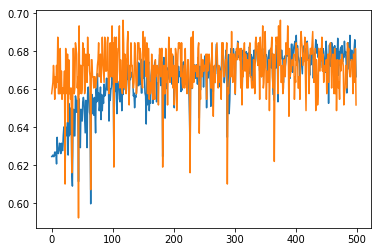

In [46]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(297, 13) (297,)
0.6902356902356902
[0.69023569 0.        ]
1
(297, 13) (297,)
0.4478114478114478
[0.69023569 0.44781145]
2


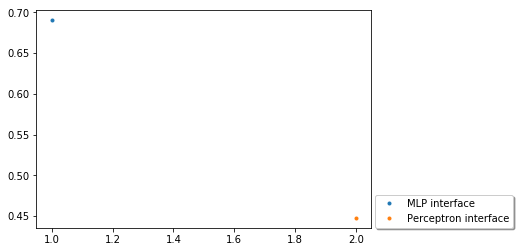

best is MLP interface with score 0.69


In [47]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [48]:
data_traffic = my_MLP.predict(X,y, fill_up=True)

# Data ARPU

In [49]:
X = df_filled[traffic_columns]
y = df_filled['DataArpu'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1270, test size 223


run=1 tscore=0.277445 vscore=0.261194
run=2 tscore=0.452096 vscore=0.402985
run=3 tscore=0.456088 vscore=0.395522
run=4 tscore=0.452096 vscore=0.402985
run=5 tscore=0.453094 vscore=0.399254
run=6 tscore=0.456088 vscore=0.399254
run=7 tscore=0.456088 vscore=0.391791
run=8 tscore=0.456088 vscore=0.380597
run=9 tscore=0.45509 vscore=0.402985
run=10 tscore=0.458084 vscore=0.395522
run=11 tscore=0.453094 vscore=0.38806
run=12 tscore=0.456088 vscore=0.395522
run=13 tscore=0.45509 vscore=0.395522
run=14 tscore=0.45509 vscore=0.38806
run=15 tscore=0.456088 vscore=0.395522
run=16 tscore=0.462076 vscore=0.395522
run=17 tscore=0.456088 vscore=0.395522
run=18 tscore=0.451098 vscore=0.384328
run=19 tscore=0.457086 vscore=0.402985
run=20 tscore=0.457086 vscore=0.399254
run=21 tscore=0.457086 vscore=0.399254
run=22 tscore=0.452096 vscore=0.38806
run=23 tscore=0.459082 vscore=0.402985
run=24 tscore=0.458084 vscore=0.391791
run=25 tscore=0.456088 vscore=0.395522
run=26 tscore=0.458084 vscore=0.402985
r

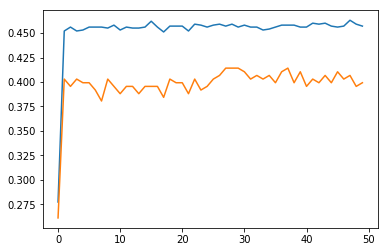

In [50]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.744322288530698 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=1 loss=1.3883646458960324 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=2 loss=1.3706931839943122 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=3 loss=1.3667316193682584 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=4 loss=1.3584575800340433 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=5 loss=1.3525671371353647 tscore=0.4540918163672655 vscore=0.39925373134328357
epoch=6 loss=1.3597388879988055 tscore=0.4491017964071856 vscore=0.41044776119402987
epoch=7 loss=1.3609369790191619 tscore=0.4481037924151697 vscore=0.4141791044776119
epoch=8 loss=1.3471079733758398 tscore=0.46407185628742514 vscore=0.3843283582089552
epoch=9 loss=1.3439641445611932 tscore=0.4471057884231537 vscore=0.4141791044776119
epoch=10 loss=1.3628362340382887 tscore=0.4540918163672655 vscore=0.40671641791044777
epoch=11 loss=1.345592010120741 tscore=0.4500998003992016 vscore=0.4104477611

epoch=103 loss=1.3422268595468858 tscore=0.4491017964071856 vscore=0.41044776119402987
epoch=104 loss=1.3395141130270702 tscore=0.4630738522954092 vscore=0.3843283582089552
epoch=105 loss=1.3340783719571327 tscore=0.4550898203592814 vscore=0.39552238805970147
epoch=106 loss=1.3440831854470248 tscore=0.4560878243512974 vscore=0.3843283582089552
epoch=107 loss=1.342331974637363 tscore=0.4481037924151697 vscore=0.41044776119402987
epoch=108 loss=1.3443577531397988 tscore=0.41916167664670656 vscore=0.35447761194029853
epoch=109 loss=1.3337792373928652 tscore=0.45109780439121755 vscore=0.41044776119402987
epoch=110 loss=1.3326193309453214 tscore=0.46506986027944114 vscore=0.3880597014925373
epoch=111 loss=1.3426452021837838 tscore=0.468063872255489 vscore=0.3805970149253731
epoch=112 loss=1.3330594696824638 tscore=0.4560878243512974 vscore=0.41044776119402987
epoch=113 loss=1.3372100204011805 tscore=0.45808383233532934 vscore=0.39552238805970147
epoch=114 loss=1.3322811402963126 tscore=0.46

epoch=209 loss=1.33035414274989 tscore=0.46407185628742514 vscore=0.40671641791044777
epoch=210 loss=1.327347533571683 tscore=0.4630738522954092 vscore=0.3694029850746269
epoch=211 loss=1.335472507715534 tscore=0.4620758483033932 vscore=0.3619402985074627
epoch=212 loss=1.3270853020266606 tscore=0.4560878243512974 vscore=0.40671641791044777
epoch=213 loss=1.3334149005375306 tscore=0.4550898203592814 vscore=0.3917910447761194
epoch=214 loss=1.3294003719449294 tscore=0.4600798403193613 vscore=0.3843283582089552
epoch=215 loss=1.3299508317807867 tscore=0.46706586826347307 vscore=0.3805970149253731
epoch=216 loss=1.3262035742412028 tscore=0.4630738522954092 vscore=0.39925373134328357
epoch=217 loss=1.3260466926360281 tscore=0.4600798403193613 vscore=0.40671641791044777
epoch=218 loss=1.3336716594108466 tscore=0.4600798403193613 vscore=0.40298507462686567
epoch=219 loss=1.3244620019648226 tscore=0.4590818363273453 vscore=0.376865671641791
epoch=220 loss=1.3302714110176956 tscore=0.458083832

epoch=304 loss=1.3372208157552132 tscore=0.46706586826347307 vscore=0.3656716417910448
epoch=305 loss=1.327667893321154 tscore=0.468063872255489 vscore=0.3805970149253731
epoch=306 loss=1.3212963433112408 tscore=0.46706586826347307 vscore=0.3805970149253731
epoch=307 loss=1.3248168357707193 tscore=0.4630738522954092 vscore=0.3619402985074627
epoch=308 loss=1.320697853521142 tscore=0.46107784431137727 vscore=0.4141791044776119
epoch=309 loss=1.3212509739691987 tscore=0.4600798403193613 vscore=0.40298507462686567
epoch=310 loss=1.318710988639481 tscore=0.4600798403193613 vscore=0.3917910447761194
epoch=311 loss=1.3198696837114499 tscore=0.4590818363273453 vscore=0.40298507462686567
epoch=312 loss=1.3222337024150494 tscore=0.4411177644710579 vscore=0.3358208955223881
epoch=313 loss=1.3268942731420303 tscore=0.4750499001996008 vscore=0.3805970149253731
epoch=314 loss=1.3178275393922285 tscore=0.45808383233532934 vscore=0.41044776119402987
epoch=315 loss=1.3283625228348936 tscore=0.45409181

epoch=406 loss=1.3194845332159306 tscore=0.4780439121756487 vscore=0.39552238805970147
epoch=407 loss=1.318736156856728 tscore=0.4810379241516966 vscore=0.39552238805970147
epoch=408 loss=1.3172691435725554 tscore=0.47904191616766467 vscore=0.39552238805970147
epoch=409 loss=1.3170549795436408 tscore=0.4780439121756487 vscore=0.3917910447761194
epoch=410 loss=1.3161030697233669 tscore=0.46407185628742514 vscore=0.39925373134328357
epoch=411 loss=1.3201806319012133 tscore=0.4630738522954092 vscore=0.39925373134328357
epoch=412 loss=1.3200295550107097 tscore=0.437125748502994 vscore=0.3880597014925373
epoch=413 loss=1.327181822651645 tscore=0.47005988023952094 vscore=0.3880597014925373
epoch=414 loss=1.3141231137101974 tscore=0.46407185628742514 vscore=0.40298507462686567
epoch=415 loss=1.3139725415426096 tscore=0.46506986027944114 vscore=0.3619402985074627
epoch=416 loss=1.3164740283919005 tscore=0.4660678642714571 vscore=0.3619402985074627
epoch=417 loss=1.3212842428937404 tscore=0.459

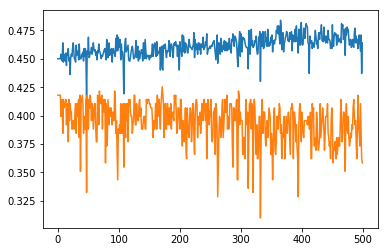

In [51]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(223, 13) (223,)
0.4663677130044843
[0.46636771 0.        ]
1
(223, 13) (223,)
0.5112107623318386
[0.46636771 0.51121076]
2


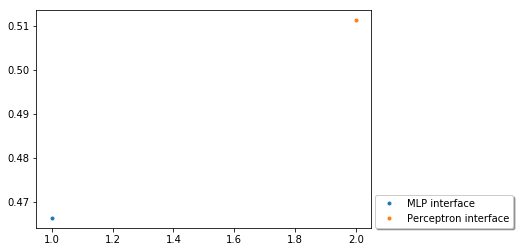

best is Perceptron interface with score 0.51


In [52]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [53]:
data_arpu = my_MLP.predict(X,y, fill_up=True)

# Monthly Voice Traffic Count

In [54]:
X = df_filled[traffic_columns]
y = df_filled['MonthlyVoiceTrafficCount'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1614, test size 303


run=1 tscore=0.336463 vscore=0.330357
run=2 tscore=0.43662 vscore=0.369048
run=3 tscore=0.43975 vscore=0.372024
run=4 tscore=0.438185 vscore=0.366071
run=5 tscore=0.438967 vscore=0.366071
run=6 tscore=0.456182 vscore=0.372024
run=7 tscore=0.441315 vscore=0.357143
run=8 tscore=0.437402 vscore=0.360119
run=9 tscore=0.449922 vscore=0.383929
run=10 tscore=0.441315 vscore=0.357143
run=11 tscore=0.460876 vscore=0.372024
run=12 tscore=0.466354 vscore=0.377976
run=13 tscore=0.444444 vscore=0.35119
run=14 tscore=0.467136 vscore=0.375
run=15 tscore=0.43975 vscore=0.360119
run=16 tscore=0.449922 vscore=0.363095
run=17 tscore=0.444444 vscore=0.35119
run=18 tscore=0.443662 vscore=0.363095
run=19 tscore=0.449922 vscore=0.363095
run=20 tscore=0.443662 vscore=0.363095
run=21 tscore=0.468701 vscore=0.375
run=22 tscore=0.456182 vscore=0.369048
run=23 tscore=0.444444 vscore=0.360119
run=24 tscore=0.447574 vscore=0.360119
run=25 tscore=0.463224 vscore=0.377976
run=26 tscore=0.438967 vscore=0.345238
run=27

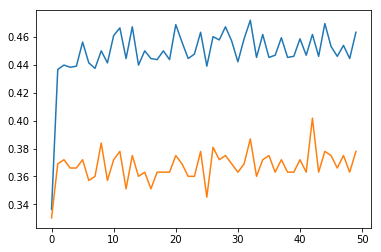

In [55]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.5652085804950153 tscore=0.486697965571205 vscore=0.4375
epoch=1 loss=1.3144318718163228 tscore=0.4694835680751174 vscore=0.42857142857142855
epoch=2 loss=1.2901005472940703 tscore=0.4702660406885759 vscore=0.41964285714285715
epoch=3 loss=1.2799780571294093 tscore=0.48826291079812206 vscore=0.42857142857142855
epoch=4 loss=1.272048348221048 tscore=0.47417840375586856 vscore=0.40773809523809523
epoch=5 loss=1.2648469490863463 tscore=0.48043818466353677 vscore=0.4166666666666667
epoch=6 loss=1.2675127028756548 tscore=0.48826291079812206 vscore=0.43154761904761907
epoch=7 loss=1.2618387378614926 tscore=0.4921752738654147 vscore=0.42857142857142855
epoch=8 loss=1.2479024812661381 tscore=0.48826291079812206 vscore=0.4226190476190476
epoch=9 loss=1.2459981886839435 tscore=0.49139280125195617 vscore=0.4226190476190476
epoch=10 loss=1.2433008580669755 tscore=0.48826291079812206 vscore=0.4255952380952381
epoch=11 loss=1.2459351754117998 tscore=0.4921752738654147 vscore=0.42559523

epoch=100 loss=1.1758194298381615 tscore=0.5242566510172144 vscore=0.4375
epoch=101 loss=1.1803803660733518 tscore=0.5179968701095462 vscore=0.43154761904761907
epoch=102 loss=1.1815343096102622 tscore=0.5352112676056338 vscore=0.43452380952380953
epoch=103 loss=1.177216737541027 tscore=0.528169014084507 vscore=0.4583333333333333
epoch=104 loss=1.1753266790019976 tscore=0.5422535211267606 vscore=0.4375
epoch=105 loss=1.1731182607268797 tscore=0.528169014084507 vscore=0.46726190476190477
epoch=106 loss=1.181440494181405 tscore=0.52660406885759 vscore=0.4494047619047619
epoch=107 loss=1.1778550558123226 tscore=0.5242566510172144 vscore=0.4375
epoch=108 loss=1.1706784529072138 tscore=0.5273865414710485 vscore=0.45535714285714285
epoch=109 loss=1.1707879462170907 tscore=0.5367762128325508 vscore=0.4642857142857143
epoch=110 loss=1.1737194679706011 tscore=0.5453834115805947 vscore=0.4375
epoch=111 loss=1.1751950168788519 tscore=0.5406885758998435 vscore=0.4375
epoch=112 loss=1.1721260248567

epoch=206 loss=1.1505790267870064 tscore=0.5688575899843505 vscore=0.4494047619047619
epoch=207 loss=1.1557193977817777 tscore=0.554773082942097 vscore=0.4494047619047619
epoch=208 loss=1.1506340245128397 tscore=0.5657276995305164 vscore=0.44047619047619047
epoch=209 loss=1.1465601437514918 tscore=0.5453834115805947 vscore=0.44642857142857145
epoch=210 loss=1.1581305906565087 tscore=0.5477308294209703 vscore=0.4494047619047619
epoch=211 loss=1.1463440896539696 tscore=0.5665101721439749 vscore=0.44642857142857145
epoch=212 loss=1.144475233112379 tscore=0.5727699530516432 vscore=0.44642857142857145
epoch=213 loss=1.141029551747176 tscore=0.5524256651017214 vscore=0.4494047619047619
epoch=214 loss=1.145258517690061 tscore=0.5633802816901409 vscore=0.4494047619047619
epoch=215 loss=1.146452281129571 tscore=0.5712050078247262 vscore=0.4375
epoch=216 loss=1.1492584040270513 tscore=0.5712050078247262 vscore=0.44642857142857145
epoch=217 loss=1.1425588630887318 tscore=0.568075117370892 vscore=

epoch=306 loss=1.1304635541478993 tscore=0.5719874804381847 vscore=0.4375
epoch=307 loss=1.1284129256865227 tscore=0.5758998435054773 vscore=0.44047619047619047
epoch=308 loss=1.130016195029416 tscore=0.5892018779342723 vscore=0.4642857142857143
epoch=309 loss=1.130853254834344 tscore=0.5727699530516432 vscore=0.4494047619047619
epoch=310 loss=1.1326374867164524 tscore=0.5845070422535211 vscore=0.45535714285714285
epoch=311 loss=1.130904656587975 tscore=0.5790297339593115 vscore=0.4583333333333333
epoch=312 loss=1.140377510173845 tscore=0.5852895148669797 vscore=0.4494047619047619
epoch=313 loss=1.1312298476491471 tscore=0.5868544600938967 vscore=0.46726190476190477
epoch=314 loss=1.1253620783707345 tscore=0.568075117370892 vscore=0.44642857142857145
epoch=315 loss=1.1333912487642706 tscore=0.57981220657277 vscore=0.4494047619047619
epoch=316 loss=1.1293754566570644 tscore=0.5860719874804382 vscore=0.45535714285714285
epoch=317 loss=1.133177262383119 tscore=0.5633802816901409 vscore=0.

epoch=405 loss=1.1252048886739179 tscore=0.5978090766823161 vscore=0.4583333333333333
epoch=406 loss=1.1193305193534986 tscore=0.57981220657277 vscore=0.4494047619047619
epoch=407 loss=1.1249289848749824 tscore=0.581377151799687 vscore=0.4375
epoch=408 loss=1.1358092469938588 tscore=0.593114241001565 vscore=0.44047619047619047
epoch=409 loss=1.120070898260584 tscore=0.594679186228482 vscore=0.4583333333333333
epoch=410 loss=1.1232281418793608 tscore=0.5751173708920188 vscore=0.44642857142857145
epoch=411 loss=1.1248641213134596 tscore=0.5993740219092332 vscore=0.4523809523809524
epoch=412 loss=1.1205755096511187 tscore=0.6009389671361502 vscore=0.4642857142857143
epoch=413 loss=1.1178646549402618 tscore=0.596244131455399 vscore=0.46130952380952384
epoch=414 loss=1.1232208896079046 tscore=0.5860719874804382 vscore=0.45535714285714285
epoch=415 loss=1.1204903228657275 tscore=0.594679186228482 vscore=0.4523809523809524
epoch=416 loss=1.1189900639565586 tscore=0.581377151799687 vscore=0.44

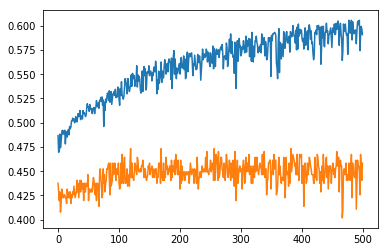

In [56]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(303, 13) (303,)
0.44884488448844884
[0.44884488 0.        ]
1
(303, 13) (303,)
0.47854785478547857
[0.44884488 0.47854785]
2


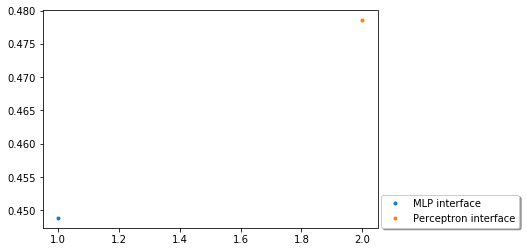

best is Perceptron interface with score 0.48


In [57]:
test_sup(*data.get_valid(), my_MLP, my_perc)

In [58]:
voice_traffic_c = my_perc.predict(X,y, fill_up=True)

In [59]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 33 columns):
ID                                2000 non-null int64
Product                           2000 non-null object
CustomerAge                       1880 non-null object
DataAllowance                     1636 non-null float64
DataArpu                          1493 non-null float64
DeviceFlag4G                      2000 non-null float64
DeviceFlagSmartphone              2000 non-null float64
MonthlyDataTraffic                1917 non-null float64
MonthlyVoiceTrafficCount          1917 non-null float64
CustomerGender                    2000 non-null float64
CustomerImmigrant                 2000 non-null float64
DevicePrice                       752 non-null float64
MonthlySmsTrafficCount            1999 non-null float64
Province                          1575 non-null object
Region                            1575 non-null object
ZipCode                           1654 non-null object
Devic